My RCNN model uses a pretrained backbone and custom fully connected layers to produce a classification and regression output. 

For the pre-trained backbone, I use resnet18 with the last layer removed, allowing for the extraction and use of features from the input images. I decided to unfreeze the weights of the backbone for improved performance while training.

After feature extraction with resnet18, I defined two fully connected layer stacks, one for regression and the other for classification. They both start by flattening the resnet output into a 1D feature vector, then passing those 512 outputs into a linear layer. This layer, then reduces that dimension down to 256, passes those features to ReLU layer then to a final linear layer. The final linear layer for classification maps the features to num_classes+1 outputs, representing the predicted class. The regression layer ends with num_classes*4 outputs, which represent the 4 corners of the predicted bounding boxes for each class.

In [23]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import numpy as np
import json
from PIL import Image
from os.path import join
from tqdm import tqdm

import cv2 as cv
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.ops import box_iou, batched_nms
import torchvision.transforms as transforms

In [24]:
"""
Implement and test the utilities in support of evaluating the results
from the region-by-region decisions and turning them into detections.

All rectangles are four component lists (or tuples) giving the upper
left and lower right cornders of an axis-aligned rectangle.  For example, 
[2, 9, 12, 18] has upper left corner (2,9) and lower right (12, 18)

The region predictions for an image for an image are stored in a list
of dictionaries, each giving the class, the activation and the
bounding rectangle.  For example,

{
    "class": 2,
    "a":  0.67,
    "rectangle": (18, 14, 50, 75)
}

if the class is 0 this means there is no detection and the rectangle
should be ignored.  The region predictions must be turned into the
detection results by filtering those with class 0 and through non
maximum supression.  The resulting regions should be considered the
"detections" for the image.

After this, detections should be compared to the ground truth 

The ground truth regions for an image are stored as a list of dictionaries. 
Each dictionary contains the region's class and bounding rectangle.
Here is an example dictionary:

{
    "class":  3,
    "rectangle": (15, 20, 56, 65)
}

Class 0 will not appear in the ground truth.  
"""


def area(rect):
    h = rect[3] - rect[1]
    w = rect[2] - rect[0]
    return h * w


def iou(rect1, rect2):
    """
    Input: two rectangles
    Output: IOU value, which should be 0 if the rectangles do not overlap.
    """ 
    x0, y0, x1, y1 = rect1
    u0, v0, u1, v1 = rect2
    ir = (max(x0, u0), max(y0, v0), min(x1, u1), min(y1, v1))
    if ir[0] >= ir[2] or ir[1] >= ir[3]:
        return 0
    else:
        return area(ir) / (area(rect1) + area(rect2) - area(ir))


def predictions_to_detections(predictions, iou_threshold=0.50):
    """
    Input: List of region predictions; 

    Output: List of region predictions that are considered to be
    detection results. These are ordered by activation with all class
    0 predictions eliminated, and the non-maximum suppression
    applied.
    """

    pred_classes = [pred['class'] for pred in predictions if pred['class'] != 0]
    activations = [pred['a'] for pred in predictions if pred['class'] != 0]
    pred_bboxes = [pred['rectangle'] for pred in predictions if pred['class'] != 0]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Convert to tensor
    pred_bboxes = torch.tensor(pred_bboxes, dtype=torch.float32, device=device)
    activations = torch.tensor(activations, dtype=torch.float32, device=device)
    pred_classes = torch.tensor(pred_classes, device=device)

    keep_indices = batched_nms(pred_bboxes, activations, pred_classes, iou_threshold)

    detections = []
    for idx in keep_indices.tolist():
        detections.append({ "class":  pred_classes[idx], 
                           "a": activations[idx], "rectangle": pred_bboxes[idx]})

    return detections
    


def evaluate(detections, gt_detections, iou_threshold=0.5):
    """
    Input:
    1. The detections returned by the predictions_to_detections function
    2. The list of ground truth regions, and
    3. The IOU threshold

    The calculation must compare each detection region to the ground
    truth detection regions to determine which are correct and which
    are incorrect.  Finally, it must compute the average precision for
    up to n detections.

    Returns:
    list of correct detections,
    list of incorrect detections,
    list of ground truth regions that are missed,
    AP@n value.
    """

    # Convert detection details to tensors for computation
    pred_bboxes = [det['rectangle'] for det in detections if det['class'] != 0]
    pred_classes = [det['class'] for det in detections if det['class'] != 0]
    pred_activations = [det['a'] for det in detections if det['class'] != 0]

    # Convert ground truth to tensors
    gt_bboxes = torch.tensor([gt['rectangle'] for gt in gt_detections], dtype=torch.float32, device='cuda')
    gt_classes = torch.tensor([gt['class'] for gt in gt_detections], device='cuda')

    correct, incorrect, missed = [], [], []
    matched_gt_indices = set()
    bin_vec = []

    # Iterate over sorted predictions by activation in descending order
    for pred_bbox, pred_class, activation in sorted(zip(pred_bboxes, pred_classes, pred_activations), key=lambda x: x[2], reverse=True):
        match_found = False

        for idx, (gt_bbox, gt_class) in enumerate(zip(gt_bboxes, gt_classes)):
            if pred_class == gt_class and idx not in matched_gt_indices:
                iou = box_iou(pred_bbox.unsqueeze(0), gt_bbox.unsqueeze(0)).item()
                if iou >= iou_threshold:
                    correct.append({'rectangle': pred_bbox, 'class': pred_class, 'a': activation})
                    matched_gt_indices.add(idx)
                    match_found = True
                    bin_vec.append(1)  # True Positive
                    break

        if not match_found:
            incorrect.append({'rectangle': pred_bbox, 'class': pred_class, 'a': activation})
            bin_vec.append(0)  # False Positive

    # Find missed detections 
    for idx in range(len(gt_detections)):
        if idx not in matched_gt_indices:
            missed.append(gt_detections[idx])

    # Calculate Average Precision (AP)
    precision = np.cumsum(bin_vec) / np.arange(1, len(bin_vec) + 1)
    recall = np.cumsum(bin_vec) / len(gt_detections)
    precision_recall_pairs = list(zip(precision, recall))
    R_j = np.linspace(0, 1, 11)  
    P_j = []
    for r_j in R_j:
        P_j.append(max((p_i for p_i, r_i in precision_recall_pairs if r_i >= r_j), default=0))

    ap = np.mean(P_j)  

    return correct, incorrect, missed, ap

In [25]:
def test_iou():
    """
    Use this function for you own testing of your IOU function
    """
    # should be .370
    rect1 = (0, 5, 11, 15)
    rect2 = (2, 9, 12, 18)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

    # should be 0
    rect1 = (2, -3, 11, 4)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

    # should be 0.2
    rect1 = (3, 12, 9, 15)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

test_iou()

iou for (0, 5, 11, 15) (2, 9, 12, 18) is 0.37
iou for (2, -3, 11, 4) (2, 9, 12, 18) is 0.00
iou for (3, 12, 9, 15) (2, 9, 12, 18) is 0.20


In [26]:
def test_evaluation_code(in_json_file):
    with open(in_json_file, "r") as in_fp:
        data = json.load(in_fp)
    
    region_predictions = data["region_predictions"]
    gt_detections = data["gt_detections"]

    detections = predictions_to_detections(region_predictions)
    print(f"DETECTIONS: count = {len(detections)}")
    if len(detections) >= 2:
        print(f"DETECTIONS: first activation {detections[0]['a']:.2f}" )
        print(f"DETECTIONS: last activation {detections[-1]['a']:.2f}")
    elif len(detections) == 1:
        print(f"DETECTIONS: only activation {detections[0]['a']:.2f}")
    else:
        print(f"DETECTIONS: no activations")

    correct, incorrect, missed, ap = evaluate(detections, gt_detections)

    print(f"AP: num correct {len(correct)}")
    if len(correct) > 0:
        print(f"AP: first correct activation {correct[0]['a']:.2f}")

    print(f"AP: num incorrect {len(incorrect)}")
    if len(incorrect) > 0:
        print(f"AP: first incorrect activation {incorrect[0]['a']:.2f}")

    print(f"AP: num ground truth missed {len(missed)}")
    print(f"AP: final AP value {ap:1.3f}")


In [27]:
test_evaluation_code('eval_test1.json')

DETECTIONS: count = 3
DETECTIONS: first activation 0.90
DETECTIONS: last activation 0.69
AP: num correct 1
AP: first correct activation 0.90
AP: num incorrect 2
AP: first incorrect activation 0.70
AP: num ground truth missed 2
AP: final AP value 0.364


In [28]:
test_evaluation_code('eval_test2.json')

DETECTIONS: count = 5
DETECTIONS: first activation 0.94
DETECTIONS: last activation 0.55
AP: num correct 4
AP: first correct activation 0.90
AP: num incorrect 1
AP: first incorrect activation 0.94
AP: num ground truth missed 1
AP: final AP value 0.655


In [29]:
test_evaluation_code('eval_test3.json')

DETECTIONS: count = 1
DETECTIONS: only activation 0.94
AP: num correct 0
AP: num incorrect 1
AP: first incorrect activation 0.94
AP: num ground truth missed 1
AP: final AP value 0.000


In [30]:
test_evaluation_code('eval_test4.json')

DETECTIONS: count = 11
DETECTIONS: first activation 0.89
DETECTIONS: last activation 0.65
AP: num correct 10
AP: first correct activation 0.89
AP: num incorrect 1
AP: first incorrect activation 0.88
AP: num ground truth missed 1
AP: final AP value 0.835


In [31]:

class RCNN(nn.Module):
    def __init__(self, num_classes):
        super(RCNN, self).__init__()

        # Pretrained backbone. 
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Remove the last fc layer of the pretrained network.
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
  
        # # Freeze backbone weights. 
        # for param in self.backbone.parameters():
        #     param.requires_grad = False

        # Fully connected layers for classification and regression.
        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes+1)
        )

        self.regression = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes*4)
        )
            
    def forward(self, x):
        x = self.backbone(x)
        x = x.flatten(start_dim=1)
        x1 = self.classification(x)
        x2 = self.regression(x)
        
        return x1, x2


In [32]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


# Dictionaries mapping class labels to names.
LABELS_TO_NAMES = {0: 'nothing',
                   1: 'bicycle',
                   2: 'car',
                   3: 'motorbike',
                   4: 'person',}


LABELS_TO_NAMES_LARGE = {0: 'nothing',
                         1: 'aeroplane',
                         2: 'bicycle',
                         3: 'bird',
                         4: 'boat',
                         5: 'bottle',
                         6: 'bus',
                         7: 'car',
                         8: 'cat',
                         9: 'chair',
                         10: 'cow',
                         11: 'diningtable',
                         12: 'dog',
                         13: 'horse',
                         14: 'motorbike',
                         15: 'person',
                         16: 'pottedplant',
                         17: 'sheep',
                         18: 'sofa',
                         19: 'train',
                         20: 'tvmonitor'}


class HW5Dataset(Dataset):
    '''
    Dataset for Train and Validation.
    Input:
        data_root - path to either the train or valid image directories
        json_file - path to either train.json or valid.json
    Output:
        candidate_region - 3 x M x M tensor
        ground_truth_bbox - 1 x 4 tensor
        ground_truth_class
    '''
    def __init__(self, data_root, json_file, candidate_region_size=224):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root
        self.candidate_region_size = candidate_region_size

        self.images = []
        self.candidate_bboxes = torch.empty((0, 4), dtype=int)
        self.ground_truth_bboxes = torch.empty((0, 4), dtype=int)
        self.ground_truth_classes = torch.empty(0, dtype=int)
        for key, values in data_dict.items():
            for val in values:
                self.images.append(key)
                self.candidate_bboxes = torch.cat((self.candidate_bboxes, torch.tensor(val['bbox']).unsqueeze(0)))
                self.ground_truth_bboxes = torch.cat((self.ground_truth_bboxes, torch.tensor(val['gt_bbox']).unsqueeze(0)))
                self.ground_truth_classes = torch.cat((self.ground_truth_classes, torch.tensor(val['class']).unsqueeze(0)))

        # Transform to convert to tensor, resize, and normalize.
        self.transform = transforms.Compose([transforms.Resize((candidate_region_size, candidate_region_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])
        
        image = Image.open(image_path)

        # Crop the image to the candidate region.
        candidate_bbox = self.candidate_bboxes[idx, :]
        candidate_region = image.crop((candidate_bbox[0].item(), candidate_bbox[1].item(), candidate_bbox[2].item(), candidate_bbox[3].item()))
        
        width, height = candidate_region.size
        x_scale = self.candidate_region_size / width
        y_scale = self.candidate_region_size / height

        # Transform to resize, convert to tensor, and normalize.
        candidate_region = self.transform(candidate_region)
        
        # Resize ground truth bounding box.
        gt_bbox = self.ground_truth_bboxes[idx, :]
        resized_gt_x0 = (gt_bbox[0] - candidate_bbox[0]) * x_scale / self.candidate_region_size
        resized_gt_y0 = (gt_bbox[1] - candidate_bbox[1]) * y_scale / self.candidate_region_size
        resized_gt_x1 = (gt_bbox[2] - candidate_bbox[0]) * x_scale / self.candidate_region_size
        resized_gt_y1 = (gt_bbox[3] - candidate_bbox[1]) * y_scale / self.candidate_region_size
        
        resized_gt_bbox = torch.tensor([resized_gt_x0, resized_gt_y0, resized_gt_x1, resized_gt_y1])
        
        return candidate_region, resized_gt_bbox, self.ground_truth_classes[idx]


class HW5DatasetTest(Dataset):
    """
    Dataset for Test.
    Input:
        data_root - path to the test image directory
        json_file - path to test.json
    Returns:
        image - numpy array A x B x 3 (RGB)
        candidate_regions - NUM_CANDIDATE_REGIONS x 3 x M x M tensor
        candidate_bboxes - all candidate bounding boxes for an image 
        ground_truth_bboxes - all ground truth bounding boxes for an image
        ground_truth_classes - all ground truth classes for an image
    """
    def __init__(self, data_root, json_file, candidate_region_size=224):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root

        self.images = []
        self.candidate_bboxes = []
        self.ground_truth_bboxes = []
        self.ground_truth_classes = []
        for key, values in data_dict.items():
            self.images.append(key)

            bboxes = torch.empty((len(values['candidate_bboxes']), 4), dtype=int)
            for i, bbox in enumerate(values['candidate_bboxes']):
                bboxes[i, :] = torch.tensor(bbox)
            self.candidate_bboxes.append(bboxes)

            labels = torch.empty((len(values['gt_bboxes'])), dtype=int)
            bboxes = torch.empty((len(values['gt_bboxes']), 4), dtype=int)
            for i, bbox in enumerate(values['gt_bboxes']):
                bboxes[i, :] = torch.tensor(bbox['bbox'])
                labels[i] = bbox['class']
            self.ground_truth_bboxes.append(bboxes)
            self.ground_truth_classes.append(labels)

        self.candidate_region_size = candidate_region_size

        # Transform to resize, convert to tensor, and normalize.
        self.transform = transforms.Compose([transforms.Resize((candidate_region_size, candidate_region_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])
        image = Image.open(image_path)

        # Apply transform to resize and normalize the candidate images.
        idx_candidate_bboxes = self.candidate_bboxes[idx]
        candidate_regions = torch.empty((len(idx_candidate_bboxes), 3, self.candidate_region_size, self.candidate_region_size))
        for i, bbox in enumerate(idx_candidate_bboxes):
            candidate_region = image.crop((bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()))
            candidate_region = self.transform(candidate_region)
            candidate_regions[i] = candidate_region

        return np.array(image), candidate_regions, self.candidate_bboxes[idx], self.ground_truth_bboxes[idx], self.ground_truth_classes[idx]


In [33]:
# Filters pred_bbox by class
def process_pred_bbox(pred_bbox, true_class):
    device = pred_bbox.device
    valid_indices = true_class != 0

    pred_bbox_selected = torch.tensor([], device=device, dtype=torch.float32)
    selection_mask = torch.zeros_like(true_class, dtype=torch.bool)

    if valid_indices.any():
        selected_indices = true_class[valid_indices].long() * 4 - 4
        indices = selected_indices.unsqueeze(1) + torch.arange(4, device=device).unsqueeze(0)
        pred_bbox_selected = torch.gather(pred_bbox[valid_indices], 1, indices)
        selection_mask[valid_indices] = True

    return pred_bbox_selected, selection_mask

# Computes prediction accuracy of a batch
def compute_accuracy(pred_class, true_class, pred_bbox, true_bbox, iou_threshold=0.5):
    _, pred_class = torch.max(pred_class, dim=1)
    correct_class_mask = (pred_class == true_class).float()
    
    pred_bbox_selected, bbox_selected_mask = process_pred_bbox(pred_bbox, true_class)
    avg_acc = correct_class_mask.sum().item() / true_class.size(0)

    avg_iou = 0.0

    if pred_bbox_selected.numel() > 0:
        ious = box_iou(pred_bbox_selected, true_bbox[bbox_selected_mask])
        correct_bboxes_mask = ious.diag() >= iou_threshold

        # Filter IoUs for correct predictions only
        correct_ious = ious.diag()[correct_class_mask[bbox_selected_mask].bool() & correct_bboxes_mask]
        
        if correct_ious.numel() > 0:
            avg_iou = correct_ious.mean().item()  # Calculate average IoU for correct predictions

        acc_mask = correct_class_mask[bbox_selected_mask] * correct_bboxes_mask.float()
        avg_acc = (acc_mask).sum().item() / bbox_selected_mask.sum().item()

    # Also return true and predicted labels
    return avg_acc, avg_iou, (pred_class.tolist(), true_class.tolist())


class CombinedLoss(nn.Module):
    def __init__(self, lambda_1=1, lambda_2=1):
        super(CombinedLoss, self).__init__()
        
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.class_loss_func = nn.CrossEntropyLoss()

    def forward(self, pred_class, true_class, pred_bbox, true_bbox):
        # Compute classification loss
        class_loss = self.class_loss_func(pred_class, true_class)

        # Initialize regression loss to 0
        reg_loss = torch.tensor(0.0, device=pred_bbox.device, requires_grad=True)

        # Filter bbox preditions relevant to class
        pred_bbox_selected, _ = process_pred_bbox(pred_bbox, true_class)

        if pred_bbox_selected.numel() > 0:  # Ensure tensor is not empty
            reg_loss = torch.mean((pred_bbox_selected - true_bbox[true_class != 0]) ** 2)

        # Combine losses
        combined_loss = self.lambda_1 * class_loss + self.lambda_2 * reg_loss

        return combined_loss
    

In [34]:
# Configure Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyperparameters
NUM_CLASSES = 4
LEARNING_RATE = 0.01
NUM_EPOCHS = 10
IOU_THRESHOLD = 0.5
LAMBDA_1, LAMBDA_2 = 2, 1
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64

# Instantiate Model
model = RCNN(num_classes=NUM_CLASSES).to(device)

# Construct optimizer and loss function
loss_fn = CombinedLoss(LAMBDA_1, LAMBDA_2)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

In [35]:
def train_RCNN(train_dataloader, model, loss_fn, optimizer, epoch):
    total_loss, total_ious = 0, 0
    pred_classes, true_classes = [], []

    model.train()
    
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}', ncols=100,
                        bar_format='{l_bar}{bar:10}| {n_fmt}/{total_fmt} [{rate_fmt}{postfix}]')

    for batch_num, (candidate, true_bbox, true_class) in enumerate(progress_bar):
        candidate, true_class, true_bbox = [x.to(device) for x in [candidate, true_class, true_bbox]]

        pred_class, pred_bbox = model(candidate)
        loss = loss_fn(pred_class, true_class, pred_bbox, true_bbox)
        _, iou, pred_vs_true = compute_accuracy(pred_class, true_class, pred_bbox, true_bbox, IOU_THRESHOLD)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip the gradients
        optimizer.step()

        pred_classes.extend(pred_vs_true[0])
        true_classes.extend(pred_vs_true[1])

        total_loss += loss.item()
        total_ious += iou

        avg_iou = total_ious / (batch_num + 1)
        avg_loss = total_loss / (batch_num + 1)

        progress_bar.set_postfix_str(f"TRAINING: Avg Loss: {avg_loss:.4f}, Avg IoU: {avg_iou:.2f}")

    avg_loss = total_loss / len(train_dataloader)
    avg_iou = total_ious / len(train_dataloader)

    return avg_loss, avg_iou, (pred_classes, true_classes)


def validate_RCNN(valid_dataloader, model, loss_fn, epoch):
    total_loss, total_ious = 0, 0
    pred_classes, true_classes = [], []
    accuracies = []

    model.eval() 
    for _, (candidate, true_bbox, true_class)  in enumerate(valid_dataloader):
        candidate, true_class, true_bbox = [x.to(device) for x in [candidate, true_class, true_bbox]]

        pred_class, pred_bbox = model(candidate)
        loss = loss_fn(pred_class, true_class, pred_bbox, true_bbox)
        acc, iou, pred_vs_true  = compute_accuracy(pred_class, true_class, pred_bbox, true_bbox, IOU_THRESHOLD)

        accuracies.append(acc)
        pred_classes.extend(pred_vs_true[0])
        true_classes.extend(pred_vs_true[1])

        total_loss += loss.item()
        total_ious += iou

    avg_loss = total_loss / len(valid_dataloader)
    avg_iou = total_ious / len(valid_dataloader)
    avg_acc = sum(accuracies) / len(accuracies)

    print(f"\tVALIDATION: Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_acc:.2f}, Avg IoU {avg_iou:.2f}")

    return avg_loss, avg_iou, (pred_classes, true_classes)

In [36]:


train_dataloader = DataLoader(HW5Dataset(r'hw5_data_2024\train',r'hw5_data_2024\train.json'), 
                              shuffle=True, batch_size=TRAIN_BATCH_SIZE)
valid_dataloader = DataLoader(HW5Dataset(r'hw5_data_2024\valid',r'hw5_data_2024\valid.json'), 
                              shuffle=True, batch_size=VALID_BATCH_SIZE)

train_losses, valid_losses = [], []
train_ious, valid_ious = [], []
final_train_pred_vs_true = []
final_valid_pred_vs_true = []

# Training the model
for epoch in range(NUM_EPOCHS):
    training_results = (train_RCNN(train_dataloader, model, loss_fn, optimizer, epoch))
    validation_results = (validate_RCNN(valid_dataloader, model, loss_fn, epoch))

    # Unpack data from results
    train_loss, train_iou, train_pred_vs_true = training_results
    valid_loss, valid_iou, valid_pred_vs_true = validation_results

    # Step the scheduler on validation loss
    scheduler.step(valid_loss)

    train_losses.append(train_loss),  valid_losses.append(valid_loss)
    train_ious.append(train_iou), valid_ious.append(valid_iou)

    if epoch == NUM_EPOCHS-1:
        final_train_pred_vs_true = train_pred_vs_true
        final_valid_pred_vs_true = valid_pred_vs_true

print('Finished Training')

Epoch 1/10: 100%|██████████| 370/370 [ 2.25it/s, TRAINING: Avg Loss: 1.5875, Avg IoU: 0.60]


	VALIDATION: Avg Loss: 0.9981, Avg Accuracy: 0.54, Avg IoU 0.64


Epoch 2/10: 100%|██████████| 370/370 [ 2.28it/s, TRAINING: Avg Loss: 0.8611, Avg IoU: 0.65]


	VALIDATION: Avg Loss: 0.7767, Avg Accuracy: 0.66, Avg IoU 0.65


Epoch 3/10: 100%|██████████| 370/370 [ 2.29it/s, TRAINING: Avg Loss: 0.6846, Avg IoU: 0.65]


	VALIDATION: Avg Loss: 0.6979, Avg Accuracy: 0.69, Avg IoU 0.66


Epoch 4/10: 100%|██████████| 370/370 [ 2.30it/s, TRAINING: Avg Loss: 0.5735, Avg IoU: 0.66]


	VALIDATION: Avg Loss: 0.6446, Avg Accuracy: 0.71, Avg IoU 0.66


Epoch 5/10: 100%|██████████| 370/370 [ 2.30it/s, TRAINING: Avg Loss: 0.4897, Avg IoU: 0.67]


	VALIDATION: Avg Loss: 0.6265, Avg Accuracy: 0.73, Avg IoU 0.67


Epoch 6/10: 100%|██████████| 370/370 [ 2.33it/s, TRAINING: Avg Loss: 0.4289, Avg IoU: 0.67]


	VALIDATION: Avg Loss: 0.6223, Avg Accuracy: 0.74, Avg IoU 0.67


Epoch 7/10: 100%|██████████| 370/370 [ 2.34it/s, TRAINING: Avg Loss: 0.3657, Avg IoU: 0.67]


	VALIDATION: Avg Loss: 0.6125, Avg Accuracy: 0.76, Avg IoU 0.67


Epoch 8/10: 100%|██████████| 370/370 [ 2.34it/s, TRAINING: Avg Loss: 0.3095, Avg IoU: 0.68]


	VALIDATION: Avg Loss: 0.6134, Avg Accuracy: 0.77, Avg IoU 0.68


Epoch 9/10: 100%|██████████| 370/370 [ 2.29it/s, TRAINING: Avg Loss: 0.2699, Avg IoU: 0.68]


	VALIDATION: Avg Loss: 0.6283, Avg Accuracy: 0.77, Avg IoU 0.68


Epoch 10/10: 100%|██████████| 370/370 [ 2.24it/s, TRAINING: Avg Loss: 0.2303, Avg IoU: 0.68]


	VALIDATION: Avg Loss: 0.6549, Avg Accuracy: 0.78, Avg IoU 0.68
Finished Training


In [37]:
# Save the model
# PATH = './RCNN_model.pth'
# torch.save(model.state_dict(), PATH)        

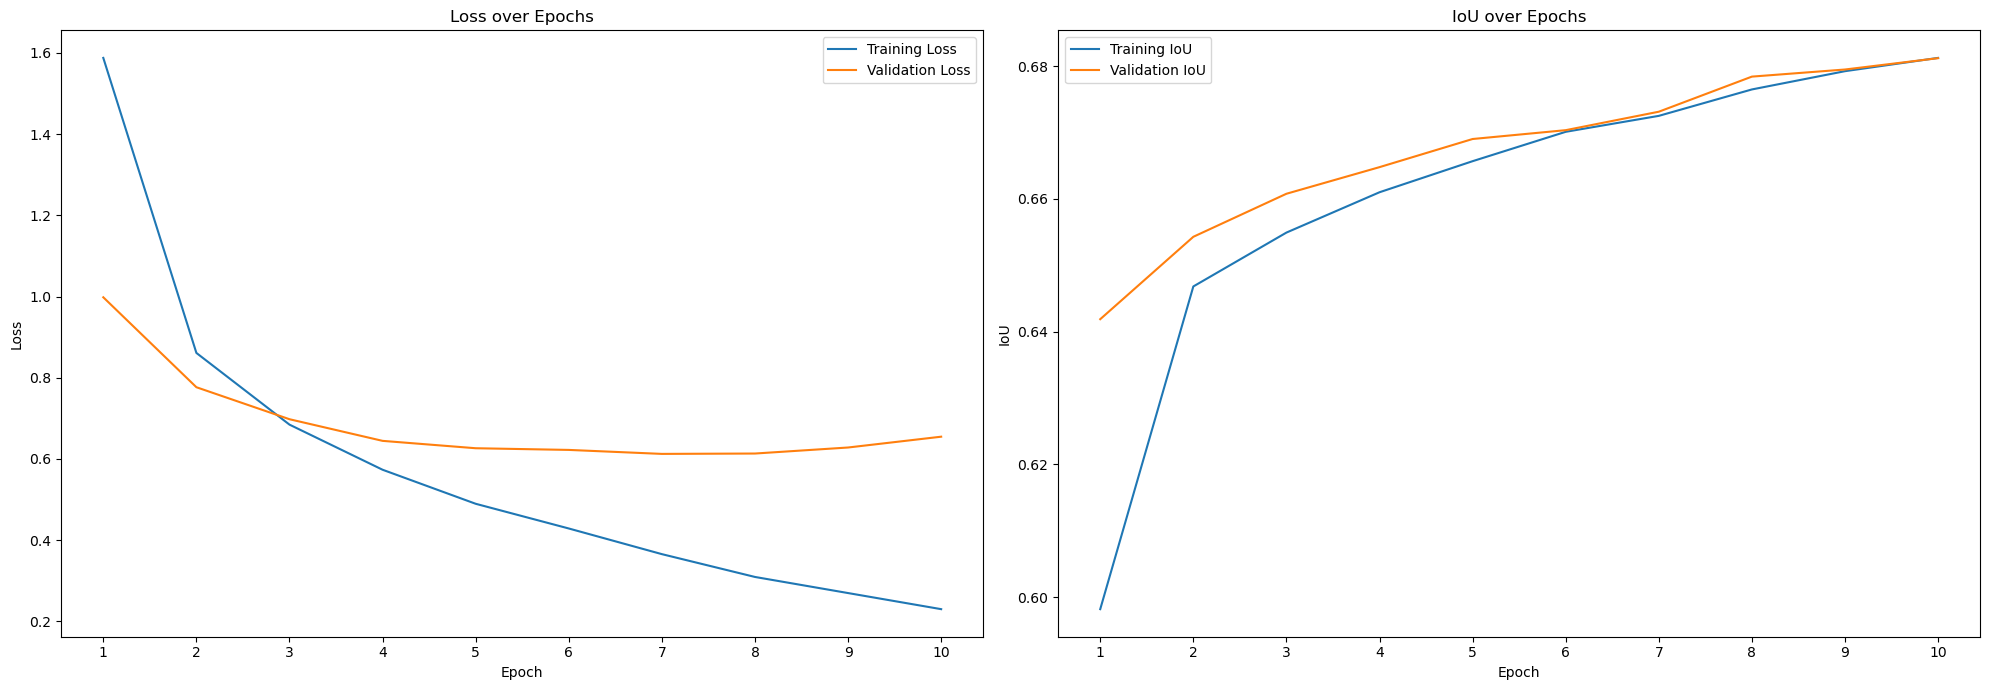

In [38]:

import matplotlib.pyplot as plt
   
fig, axes = plt.subplots(1, 2, figsize=(20, 7))  

# Plot Training and Validation Loss
axes[0].plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
axes[0].plot(range(1, NUM_EPOCHS + 1), valid_losses, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss over Epochs')
axes[0].legend()
axes[0].set_xticks(np.arange(1, NUM_EPOCHS + 1, step=1))

# Plot Training and Validation IoU
axes[1].plot(range(1, NUM_EPOCHS + 1), train_ious, label='Training IoU')
axes[1].plot(range(1, NUM_EPOCHS + 1), valid_ious, label='Validation IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('IoU over Epochs')
axes[1].legend()
axes[1].set_xticks(np.arange(1, NUM_EPOCHS + 1, step=1))

plt.tight_layout()
plt.show()

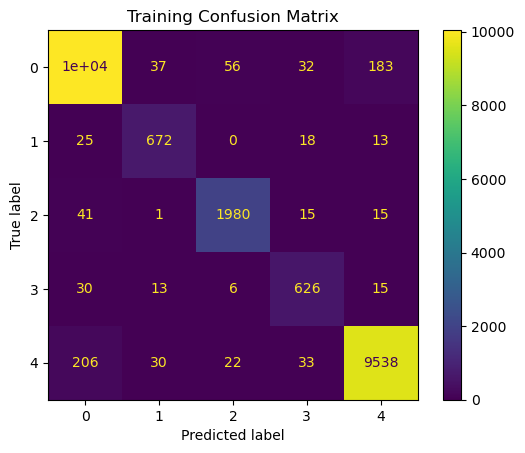

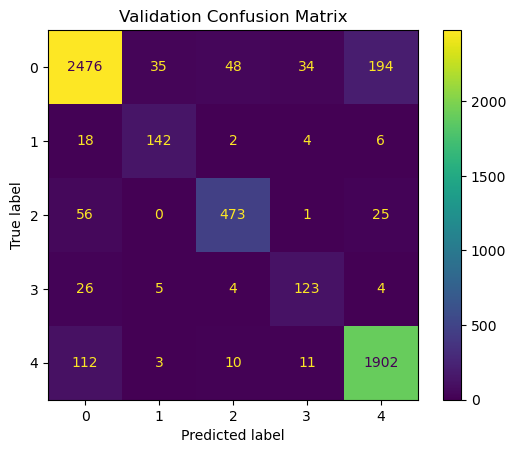

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrices
train_cm = confusion_matrix(*final_train_pred_vs_true)
valid_cm = confusion_matrix(*final_valid_pred_vs_true)

ConfusionMatrixDisplay(train_cm).plot()
plt.title("Training Confusion Matrix")
plt.show()

ConfusionMatrixDisplay(valid_cm).plot()
plt.title("Validation Confusion Matrix")
plt.show()

In [40]:
# # Read in model
# model = RCNN(num_classes=4)
# model.load_state_dict(torch.load("RCNN_model.pth"))
# model = model.to(device)

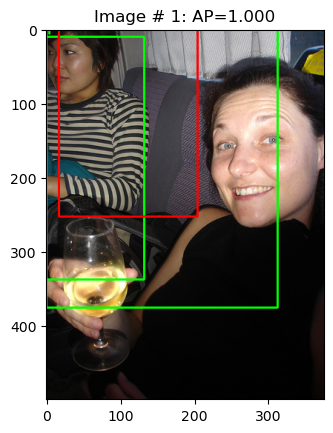

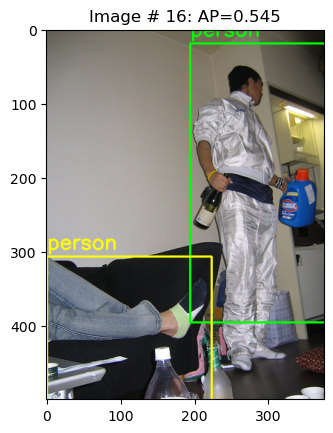

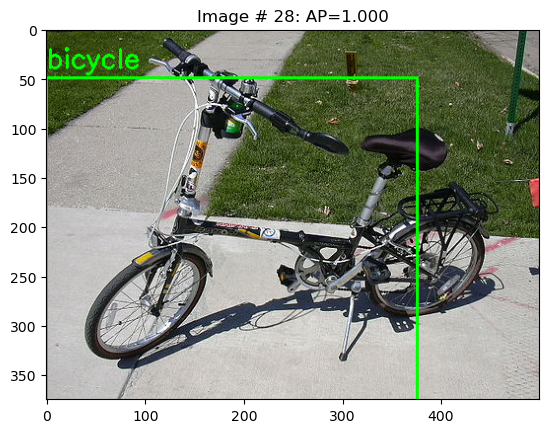

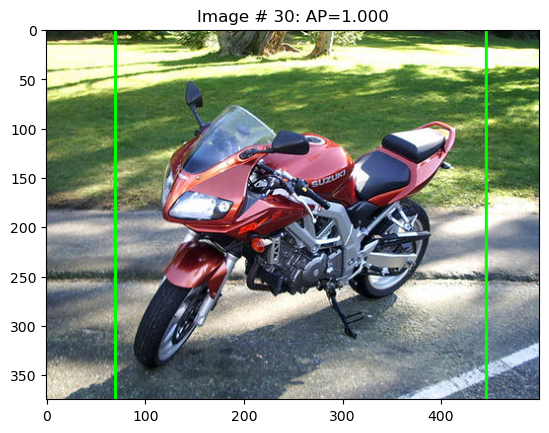

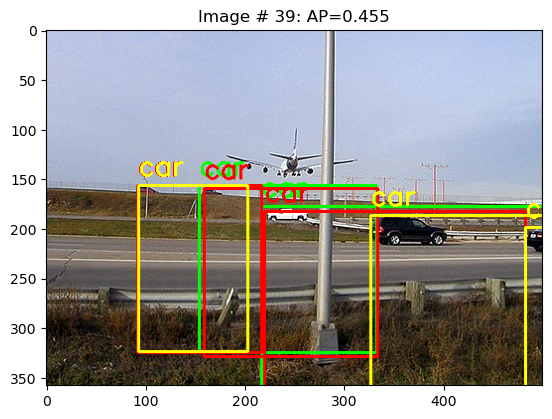

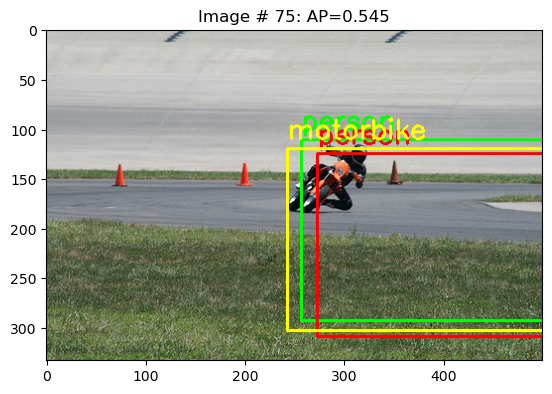

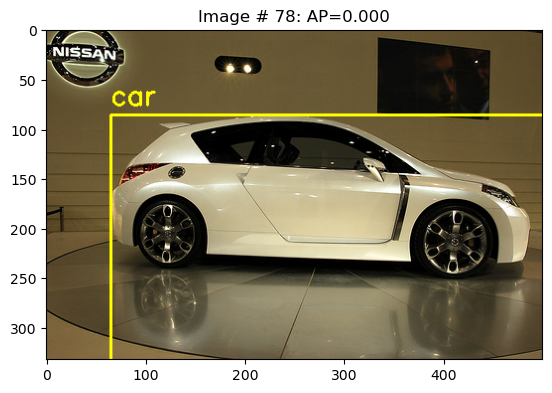

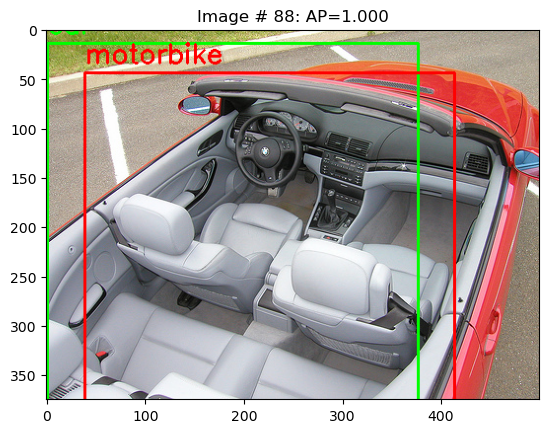

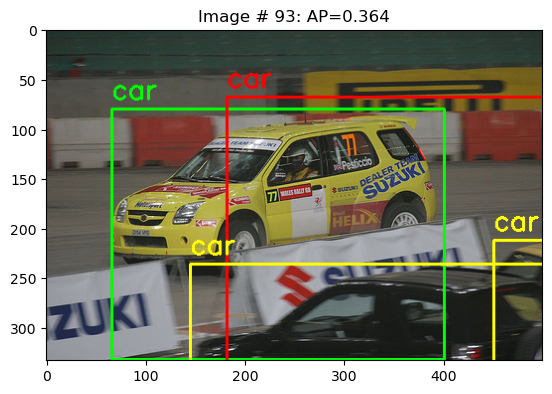

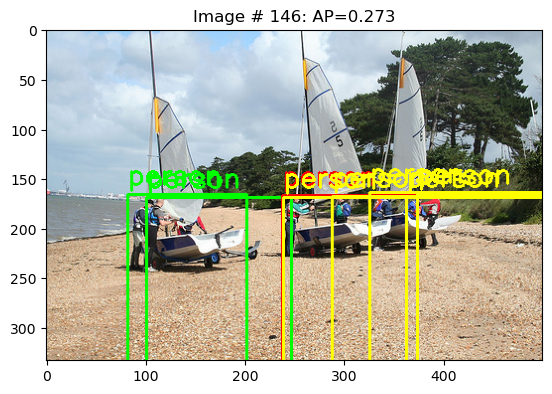

Mean Average Precision: 0.5800130753773879


In [41]:
# Testing

test_dataloader = DataLoader(HW5DatasetTest(r'hw5_data_2024\test',r'hw5_data_2024\test.json'))

ap_values = []

detailed_out_idxs = iter([1, 16, 28, 30, 39, 75, 78, 88, 93, 146])
next_out_idx = next(detailed_out_idxs)

for batch_num, test_data in enumerate(test_dataloader):
    image, cand_regions, cand_bboxes, true_bboxes, true_classes = [i.to(device) for i in test_data]
    image, cand_regions, cand_bboxes = [i[0] for i in [image, cand_regions, cand_bboxes]]

    if cand_regions.dim() == 3:
        cand_regions = cand_regions.unsqueeze(0)

    pred_classes, pred_bboxes = model(cand_regions)
    activations, pred_classes = torch.max(pred_classes, dim=1) 
    pred_bboxes, mask = process_pred_bbox(pred_bboxes, pred_classes)
    
    if mask.any():
        pred_bboxes = pred_bboxes + cand_bboxes[mask]

    predictions = []
    for idx, (pred_class, pred_bbox, activation) in enumerate(zip(pred_classes, pred_bboxes, activations)):
        predictions.append({"class": pred_class.item(), "a":activation.item(), "rectangle":pred_bbox.tolist()})

    detections = predictions_to_detections(predictions, IOU_THRESHOLD)
    gt_detections = [{"class": tc.item(), 
                      "rectangle": tb.tolist()} for tc, tb in zip(true_classes[0], true_bboxes[0])]
    
    correct, incorrect, missed, ap = evaluate(detections, gt_detections, IOU_THRESHOLD)
    ap_values.append(ap)

    if batch_num == next_out_idx:
        next_out_idx = next(detailed_out_idxs, None)

        image_np = image.cpu().numpy()
        image_np = cv.cvtColor(image_np, cv.COLOR_RGB2BGR)

        # Draw detections
        for det in correct:
            cv.rectangle(image_np, (int(det['rectangle'][0]), int(det['rectangle'][1])),
                            (int(det['rectangle'][0] + det['rectangle'][2]), int(det['rectangle'][1] + det['rectangle'][3])),
                            (0, 255, 0), 2)  # Green for correct
            cv.putText(image_np, f"{LABELS_TO_NAMES[det['class'].item()]}", (int(det['rectangle'][0]), int(det['rectangle'][1] - 10)),
                        cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        for det in incorrect:
            cv.rectangle(image_np, (int(det['rectangle'][0]), int(det['rectangle'][1])),
                            (int(det['rectangle'][0] + det['rectangle'][2]), int(det['rectangle'][1] + det['rectangle'][3])),
                            (0, 0, 255), 2)  # Red for incorrect
            cv.putText(image_np, f"{LABELS_TO_NAMES[det['class'].item()]}", (int(det['rectangle'][0]), int(det['rectangle'][1] - 10)),
                        cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        for det in missed:
            cv.rectangle(image_np, (int(det['rectangle'][0]), int(det['rectangle'][1])),
                            (int(det['rectangle'][0] + det['rectangle'][2]), int(det['rectangle'][1] + det['rectangle'][3])),
                            (0, 255, 255), 2)  # Yellow for missed
            cv.putText(image_np, f"{LABELS_TO_NAMES[det['class']]}", (int(det['rectangle'][0]), int(det['rectangle'][1] - 10)),
                        cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)
       
        plt.imshow(cv.cvtColor(image_np, cv.COLOR_BGR2RGB))
        plt.title(f'Image # {batch_num}: AP={ap:.3f}')
        plt.show()
    
map = sum(ap_values) / len(ap_values)
print(f"Mean Average Precision: {map}")

### Results Summary
The performance of my model is alright. A big issue is that the model is biased towards predicting people. It misclassifies other labels as people and predicts people where there should be nothing predicted at all. I was able to improve this aspect my increasing the lambda value associated with classification to veer my model into doing better at classification. The model also seems to frequenty miss predictions downright. In addition, bounding boxes seem to be too big and frequently extend off the image. On the otherhand, my model was able to make correct predictions in every specified testing image, and has a mean average precision score of above 50%. 